In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from salishsea_tools import viz_tools

%matplotlib inline

/home/sallen/anaconda/envs/py3/lib/python3.5/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
grid = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetry2V1')

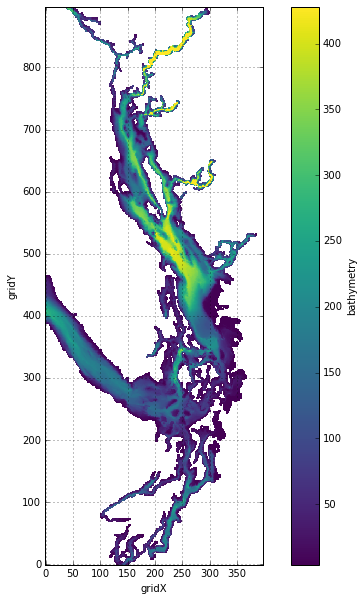

In [3]:
fig, ax = plt.subplots(figsize=(10, 10))
viz_tools.set_aspect(ax)   # just sets the correct aspect ratio for the plot
grid.bathymetry.plot(ax=ax)
ax.grid(axis='both')


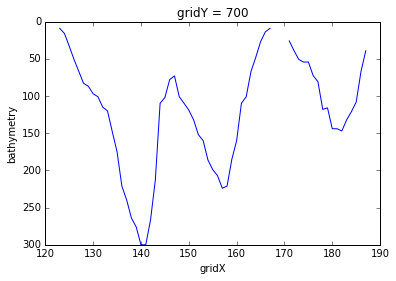

In [4]:
# based on map, select our grid points and plot bathymetry
nemo_i = 700
fig, ax = plt.subplots()
grid.bathymetry.isel(gridY=700).plot(ax=ax)
ax.invert_yaxis()

In [5]:
nemo_js = 120
nemo_je = 190
j_slice=slice(nemo_js, nemo_je)
# and a time slice
time_slice = slice('2016-04-12 12:00:00', '2016-04-15 12:00:00')

In [6]:
# sea surface height
ssh = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnSurfaceTracerFields1hV1')

ssh_ts = (ssh.ssh.isel(gridY=nemo_i, gridX=j_slice)
         .sel(time=time_slice))

print (ssh_ts)

<xarray.DataArray 'ssh' (time: 72, gridX: 70)>
array([[ 0.        ,  0.        ,  0.        , ..., -0.09501681,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.29481804,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.72660047,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  1.41274357,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  1.09731448,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.673792  ,
         0.        ,  0.        ]])
Coordinates:
  * time     (time) datetime64[ns] 2016-04-12T12:30:00 2016-04-12T13:30:00 ...
    gridY    int16 ...
  * gridX    (gridX) int16 120 121 122 123 124 125 126 127 128 129 130 131 ...
Attributes:
    interval_operation: 10.0
    interval_write: 3600.0
    long_name: sea surface height
    online_operation: ave(X)
    standard_n

In [7]:
# grid north velocity (aka v)
vvel = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DvVelocity1hV1')
vvel_ts = (
    vvel.vVelocity.isel(gridY=nemo_i, gridX=j_slice)
    .sel(time=time_slice)
)
# vvel is vertically indexed by a nominal depth, switch to indexing by gridZ
vvel_ts['gridZ'] = ('depth', range(40))
vvel_tsz = vvel_ts.swap_dims({'depth': 'gridZ'})
print (vvel_tsz)

<xarray.DataArray 'vVelocity' (time: 72, gridZ: 40, gridX: 70)>
[201600 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2016-04-12T12:30:00 2016-04-12T13:30:00 ...
    depth    (gridZ) float32 0.5 1.5 2.50001 3.50003 4.50007 5.50015 6.50031 ...
    gridY    int16 ...
  * gridX    (gridX) int16 120 121 122 123 124 125 126 127 128 129 130 131 ...
  * gridZ    (gridZ) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
Attributes:
    interval_operation: 10.0
    interval_write: 3600.0
    ioos_category: Currents
    long_name: ocean current along j-axis
    online_operation: ave(X)
    standard_name: ocean current along j-axis
    units: m/s


In [8]:
# vertical thickness of grid cells
mesh = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn3DMeshMask2V1')

dz = (mesh.e3v
     .isel(gridY=nemo_i, gridX=j_slice))
vmask = (mesh.vmask
        .isel(gridY=nemo_i, gridX=j_slice))

print (dz)
print (vmask)

<xarray.DataArray 'e3v' (t: 1, gridZ: 40, gridX: 70)>
array([[[  1.00000115,   1.00000115,   1.00000115, ...,   1.00000115,
           1.00000115,   1.00000115],
        [  1.00000501,   1.00000501,   1.00000501, ...,   1.00000501,
           1.00000501,   1.00000501],
        [  1.00001253,   1.00001253,   1.00001253, ...,   1.00001253,
           1.00001253,   1.00001253],
        ..., 
        [ 26.93002054,  26.93002054,  26.93002054, ...,  26.93002054,
          26.93002054,  26.93002054],
        [ 26.93157752,  26.93157752,  26.93157752, ...,  26.93157752,
          26.93157752,  26.93157752],
        [ 26.93237697,  26.93237697,  26.93237697, ...,  26.93237697,
          26.93237697,  26.93237697]]])
Coordinates:
  * t        (t) int32 0
  * gridZ    (gridZ) int16 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 ...
    gridY    int16 700
  * gridX    (gridX) int16 120 121 122 123 124 125 126 127 128 129 130 131 ...
Attributes:
    long_name: grid spacing on V-grid in w direct

In [9]:
north_flux = vvel_tsz * dz * vmask
print (north_flux)

<xarray.DataArray (time: 72, gridZ: 40, gridX: 70, t: 1)>
array([[[[ 0.],
         [ 0.],
         [ 0.],
         ..., 
         [ 0.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [ 0.],
         [ 0.],
         ..., 
         [ 0.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [ 0.],
         [ 0.],
         ..., 
         [ 0.],
         [ 0.],
         [ 0.]],

        ..., 
        [[ 0.],
         [ 0.],
         [ 0.],
         ..., 
         [ 0.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [ 0.],
         [ 0.],
         ..., 
         [ 0.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [ 0.],
         [ 0.],
         ..., 
         [ 0.],
         [ 0.],
         [ 0.]]],


       [[[ 0.],
         [ 0.],
         [ 0.],
         ..., 
         [ 0.],
         [ 0.],
         [ 0.]],

        [[ 0.],
         [ 0.],
         [ 0.],
         ..., 
         [ 0.],
         [ 0.],
         [ 0.]],

        [[ 0.],
      

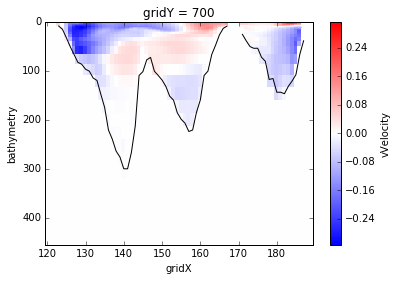

In [10]:
fig, ax = plt.subplots()
vvel_ts.isel(time=8).plot(ax=ax, cmap='bwr')
grid.bathymetry.isel(gridY=700).plot.line('k')
ax.invert_yaxis()